In [1]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from time import time
import copy
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = '/kaggle/input/eurosat-dataset'
train_dir = data_dir + '/EuroSAT'

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [3]:
# Load a pre-trained network 
model = models.maxvit_t(weights='DEFAULT')
model.name = "maxvit"
model

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [4]:
for param in model.parameters():
    param.requires_grad = False

In [5]:
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 10)  

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
model.to(device)

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [10]:
def validation(model, testloader, criterion,device):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [11]:
def train(model, trainloader, validloader, criterion, optimizer, device, epochs, steps,print_every):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion, device)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model


In [12]:
model = train(model,trainloader, validloader,criterion, optimizer,device, epochs,steps, print_every)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 1.9568 |  Validation Loss: 1.6491 |  Validation Accuracy: 0.5611
Epoch: 1/5 |  Training Loss: 1.4695 |  Validation Loss: 1.3024 |  Validation Accuracy: 0.6607
Epoch: 1/5 |  Training Loss: 1.2074 |  Validation Loss: 1.1206 |  Validation Accuracy: 0.7119
Epoch: 1/5 |  Training Loss: 1.0628 |  Validation Loss: 0.9974 |  Validation Accuracy: 0.7330
Epoch: 1/5 |  Training Loss: 0.9909 |  Validation Loss: 0.8920 |  Validation Accuracy: 0.7663
Epoch: 1/5 |  Training Loss: 0.9142 |  Validation Loss: 0.8773 |  Validation Accuracy: 0.7604
Epoch: 1/5 |  Training Loss: 0.8591 |  Validation Loss: 0.8083 |  Validation Accuracy: 0.7744
Epoch: 1/5 |  Training Loss: 0.7969 |  Validation Loss: 0.7857 |  Validation Accuracy: 0.7733
Epoch: 1/5 |  Training Loss: 0.7696 |  Validation Loss: 0.7431 |  Validation Accuracy: 0.7874
Epoch: 1/5 |  Training Loss: 0.7089 |  Validation Loss: 0.7619 |  Validation Accuracy: 0.7637
Epoch: 1/5 |  Training 

In [13]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [14]:
labels_fp32,predictions_fp32 = pred(model,testloader)

Time:  53.709025382995605
Accuracy achieved by the network on test images is: 84%


In [15]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


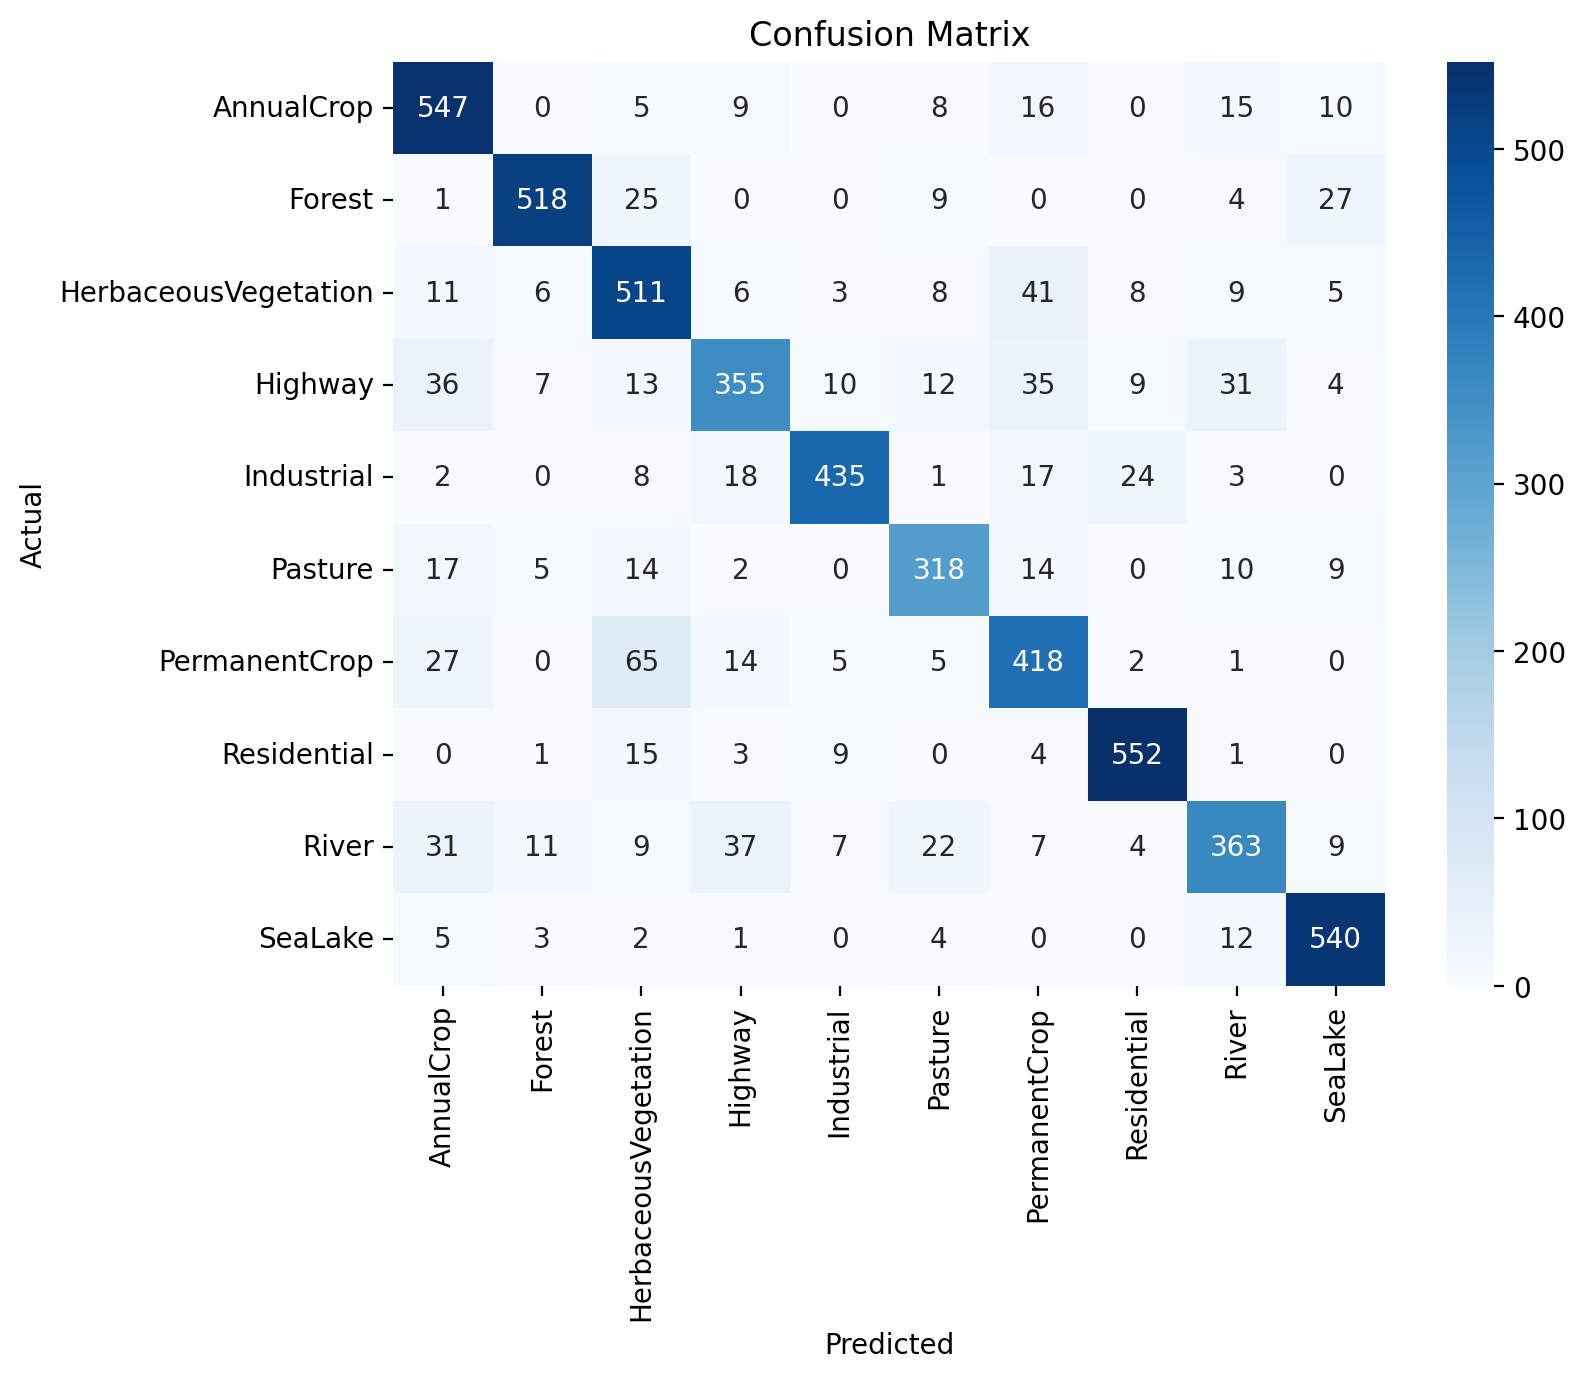

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       610
           1       0.94      0.89      0.91       584
           2       0.77      0.84      0.80       608
           3       0.80      0.69      0.74       512
           4       0.93      0.86      0.89       508
           5       0.82      0.82      0.82       389
           6       0.76      0.78      0.77       537
           7       0.92      0.94      0.93       585
           8       0.81      0.73      0.77       500
           9       0.89      0.95      0.92       567

    accuracy                           0.84      5400
   macro avg       0.84      0.84      0.84      5400
weighted avg       0.85      0.84      0.84      5400



In [16]:
metrics(labels_fp32,predictions_fp32)

In [17]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [18]:
print("Size of fp32 model:",end='')
print_model_size(model)

Size of fp32 model:122.48 MB


# Quantization

# FP-16

In [19]:
model_fp16 = copy.deepcopy(model)

In [20]:
model_fp16.half()
model_fp16.to(device)

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [21]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [22]:
labels_fp16,predictions_fp16 = pred_fp16(model_fp16,testloader)

Time:  30.595386505126953
Accuracy achieved by the network on test images is: 84%


Confusion Matrix:


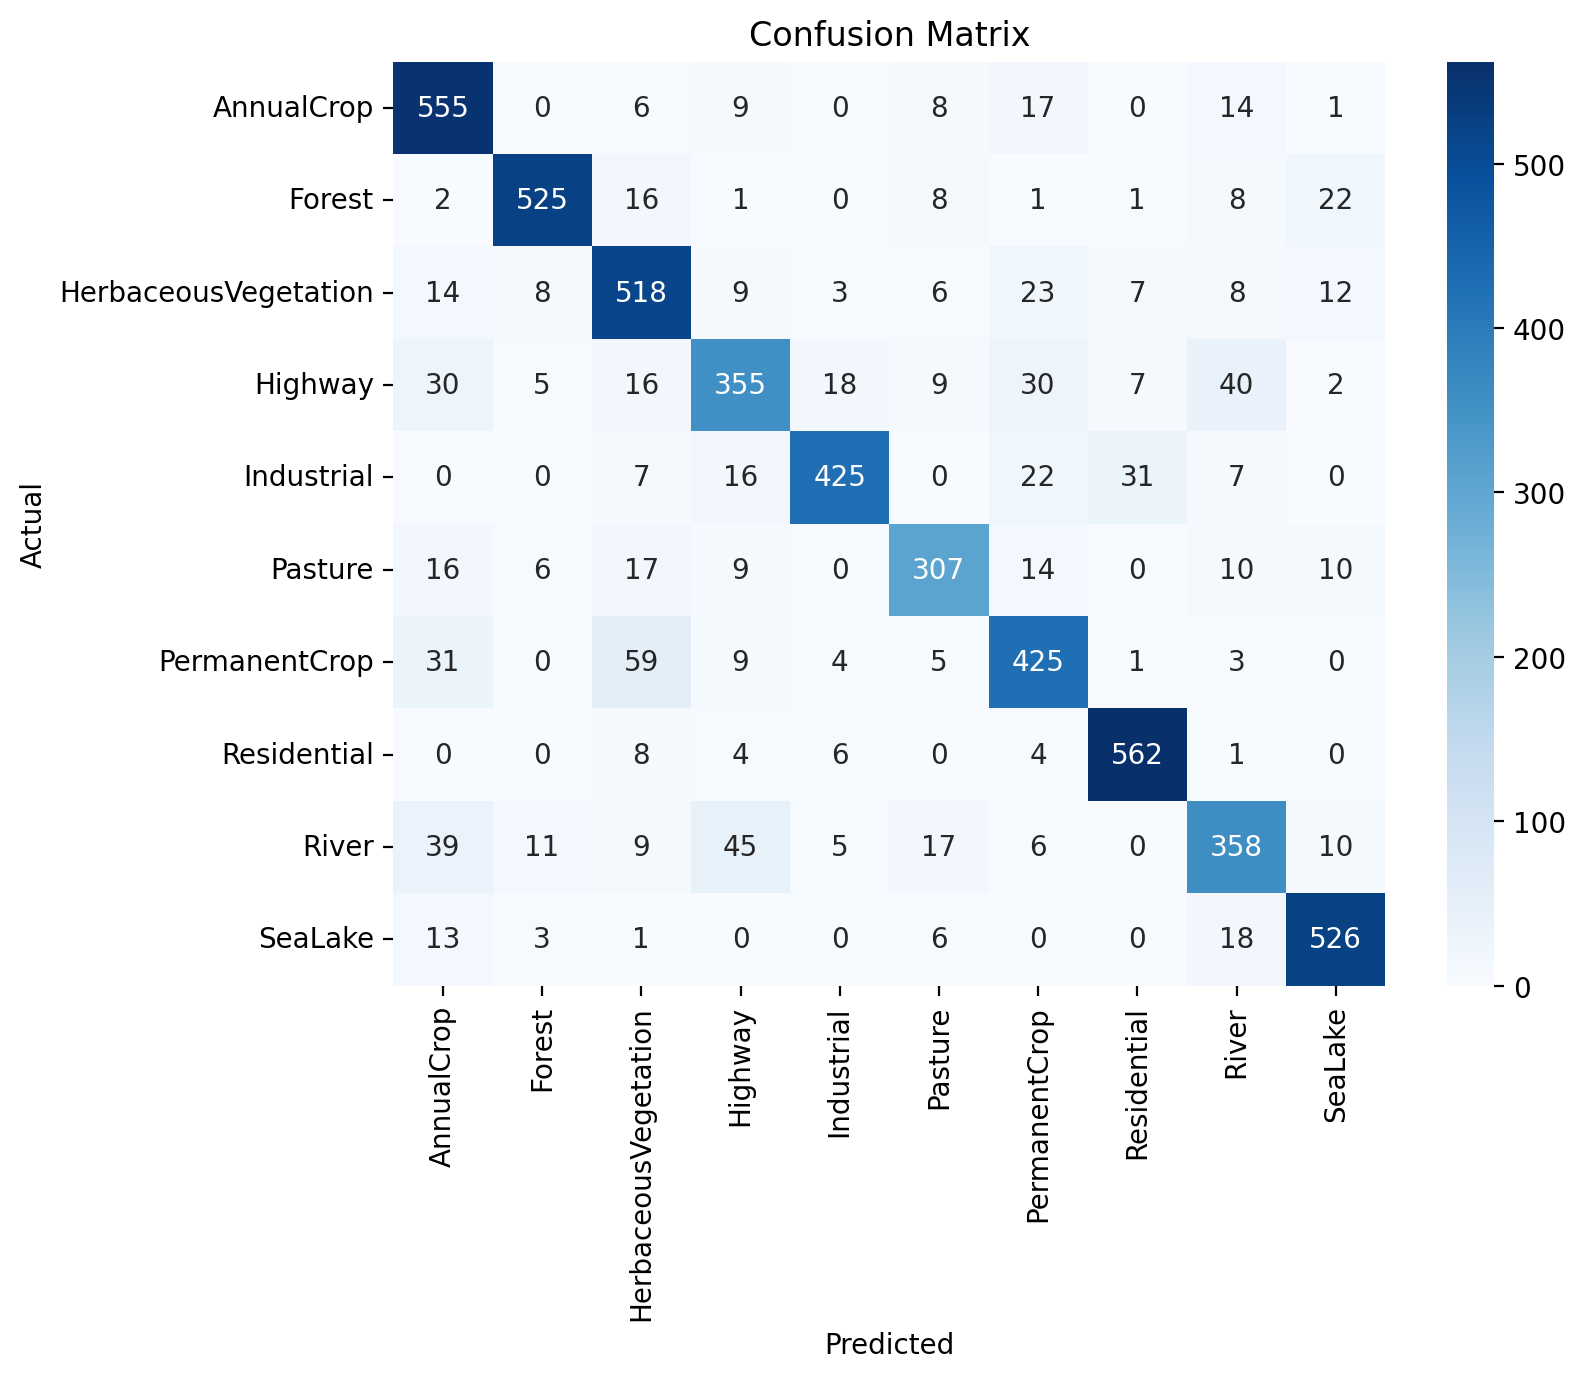

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       610
           1       0.94      0.90      0.92       584
           2       0.79      0.85      0.82       608
           3       0.78      0.69      0.73       512
           4       0.92      0.84      0.88       508
           5       0.84      0.79      0.81       389
           6       0.78      0.79      0.79       537
           7       0.92      0.96      0.94       585
           8       0.77      0.72      0.74       500
           9       0.90      0.93      0.91       567

    accuracy                           0.84      5400
   macro avg       0.84      0.84      0.84      5400
weighted avg       0.84      0.84      0.84      5400



In [23]:
metrics(labels_fp16,predictions_fp16)

# FP-64

In [24]:
model_64 = copy.deepcopy(model)
model_64.double()

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [25]:
weights_64 = model_64.state_dict()
for name, param in weights_64.items():
    print(name)

stem.0.0.weight
stem.0.1.weight
stem.0.1.bias
stem.0.1.running_mean
stem.0.1.running_var
stem.0.1.num_batches_tracked
stem.1.0.weight
stem.1.0.bias
blocks.0.layers.0.layers.MBconv.proj.1.weight
blocks.0.layers.0.layers.MBconv.proj.1.bias
blocks.0.layers.0.layers.MBconv.layers.pre_norm.weight
blocks.0.layers.0.layers.MBconv.layers.pre_norm.bias
blocks.0.layers.0.layers.MBconv.layers.pre_norm.running_mean
blocks.0.layers.0.layers.MBconv.layers.pre_norm.running_var
blocks.0.layers.0.layers.MBconv.layers.pre_norm.num_batches_tracked
blocks.0.layers.0.layers.MBconv.layers.conv_a.0.weight
blocks.0.layers.0.layers.MBconv.layers.conv_a.1.weight
blocks.0.layers.0.layers.MBconv.layers.conv_a.1.bias
blocks.0.layers.0.layers.MBconv.layers.conv_a.1.running_mean
blocks.0.layers.0.layers.MBconv.layers.conv_a.1.running_var
blocks.0.layers.0.layers.MBconv.layers.conv_a.1.num_batches_tracked
blocks.0.layers.0.layers.MBconv.layers.conv_b.0.weight
blocks.0.layers.0.layers.MBconv.layers.conv_b.1.weight
blo

In [26]:
weights_64 = model_64.state_dict()
print(weights_64['stem.0.0.weight'].dtype)
# print(weights_64['conv1.weight'].dtype)

torch.float64


In [27]:
model_64.to(device)

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [28]:
def pred_fp64(Model,Testloader): 
    all_labels = [] 
    all_predictions = [] 
    correct = 0 
    total = 0 
    start_time = time() 
    with torch.no_grad(): 
        Model.eval() 
        for images, labels in Testloader: 
            all_labels.extend(labels.numpy()) 
            images, labels = images.to(device), labels.to(device) 
            outputs = Model(images.double())
            _,predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 
            predicted_tensor_cpu = predicted.to('cpu') 
            all_predictions.extend(predicted_tensor_cpu.numpy()) 
        end_time = time() 
        print("Time: ",end_time - start_time) 
        print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
        return all_labels,all_predictions

In [29]:
labels_64,predictions_64 = pred_fp64(model_64,testloader)

Time:  644.2955906391144
Accuracy achieved by the network on test images is: 84%


Confusion Matrix:


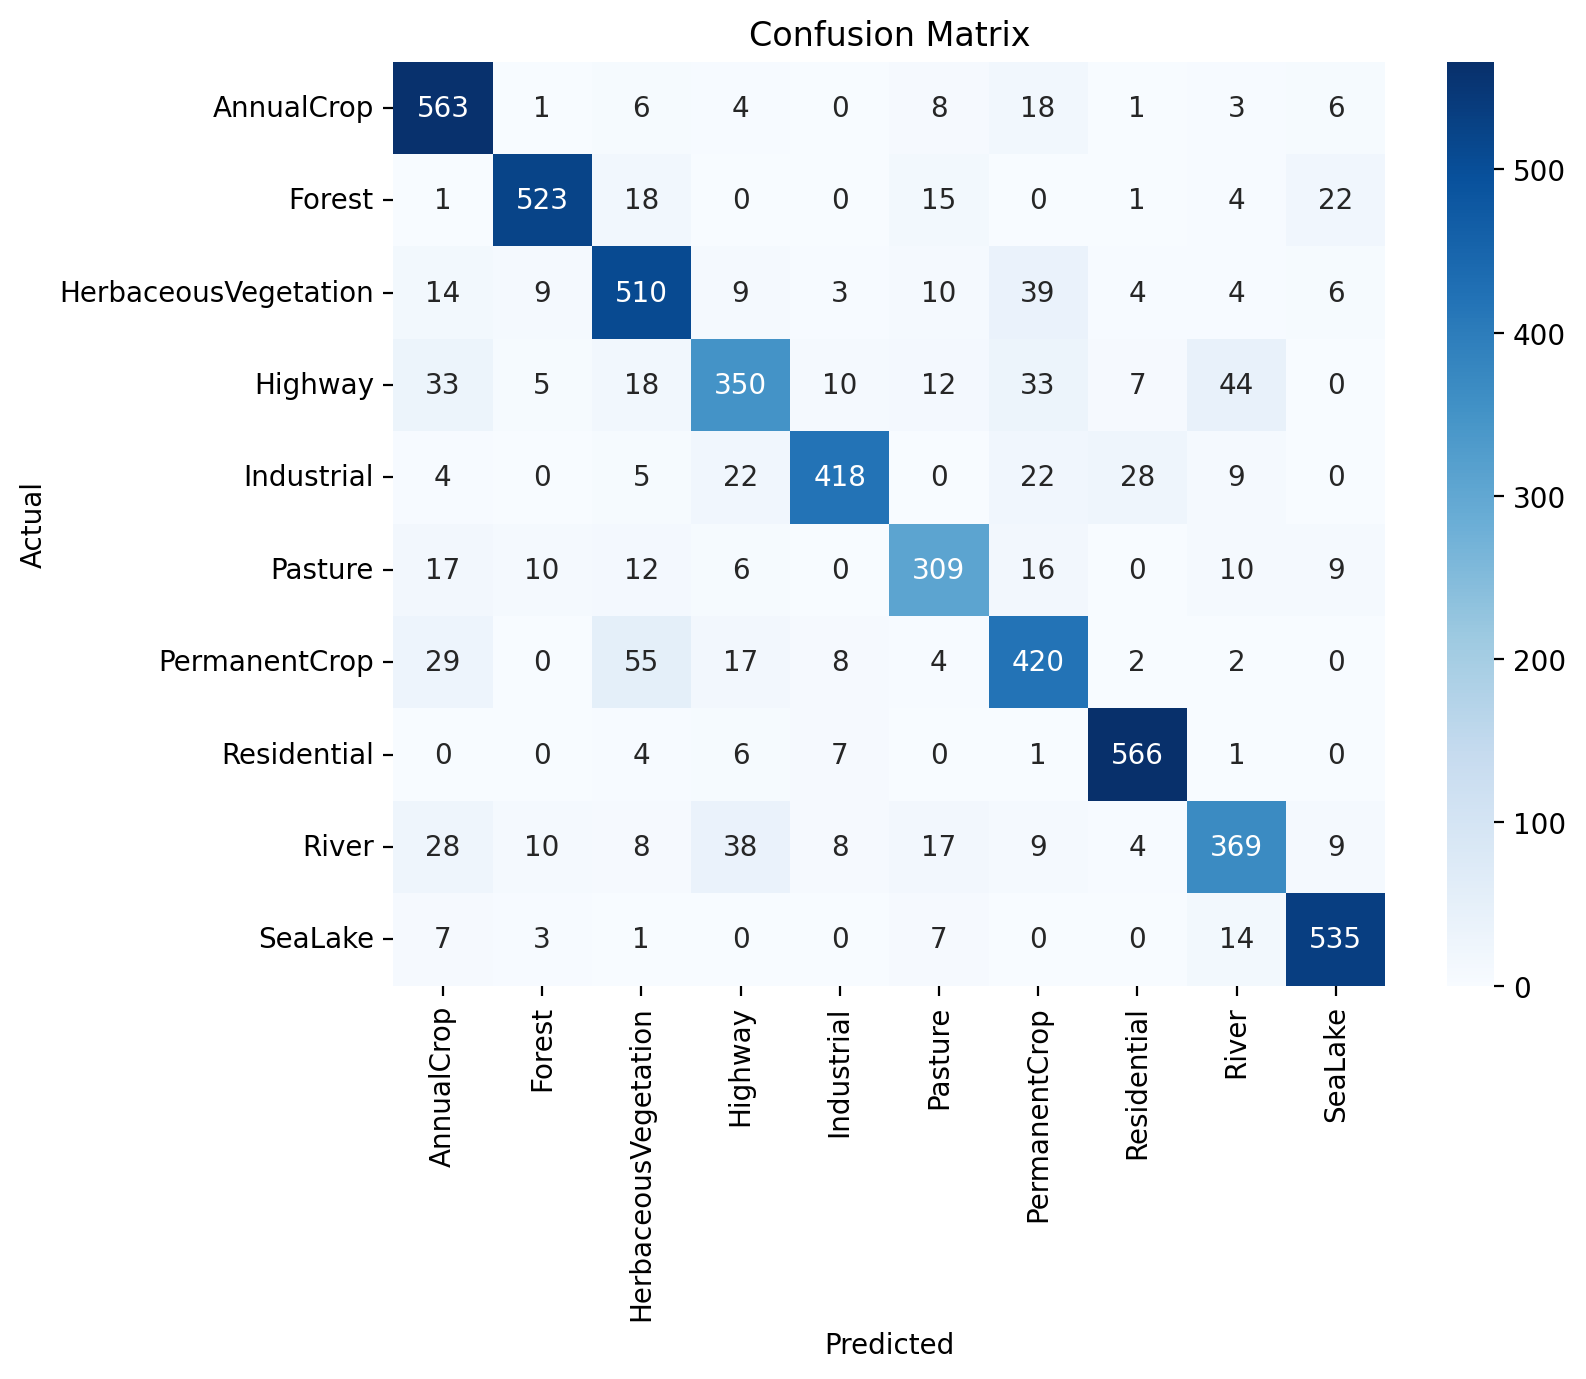

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       610
           1       0.93      0.90      0.91       584
           2       0.80      0.84      0.82       608
           3       0.77      0.68      0.73       512
           4       0.92      0.82      0.87       508
           5       0.81      0.79      0.80       389
           6       0.75      0.78      0.77       537
           7       0.92      0.97      0.94       585
           8       0.80      0.74      0.77       500
           9       0.91      0.94      0.93       567

    accuracy                           0.84      5400
   macro avg       0.84      0.84      0.84      5400
weighted avg       0.85      0.84      0.84      5400



In [30]:
metrics(labels_64,predictions_64)

## INT-8

In [31]:
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [32]:
model.to('cpu')

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [33]:
input_data = next(iter(trainloader))[0] 
calibrate_data = input_data.to("cpu")

In [34]:
model_int8 = copy.deepcopy(model)

qconfig_mapping = get_default_qconfig_mapping("x86")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate

/opt/conda/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [35]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [36]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

OrderedDict([('stem_0_0_input_scale_0', tensor(0.0346)),
             ('stem_0_0_input_zero_point_0', tensor(51)),
             ('stem_0_2_scale_0', tensor(0.0930)),
             ('stem_0_2_zero_point_0', tensor(2)),
             ('blocks_0_layers_0_layers_MBconv_layers_conv_a_2_scale_0',
              tensor(0.4059)),
             ('blocks_0_layers_0_layers_MBconv_layers_conv_a_2_zero_point_0',
              tensor(0)),
             ('blocks_0_layers_0_layers_MBconv_layers_conv_b_2_scale_0',
              tensor(0.0526)),
             ('blocks_0_layers_0_layers_MBconv_layers_conv_b_2_zero_point_0',
              tensor(3)),
             ('blocks_0_layers_0_layers_MBconv_layers_squeeze_excitation_activation_scale_0',
              tensor(0.0495)),
             ('blocks_0_layers_0_layers_MBconv_layers_squeeze_excitation_activation_zero_point_0',
              tensor(6)),
             ('blocks_0_layers_0_layers_MBconv_layers_squeeze_excitation_scale_0',
              tensor(0.0360)),
   

In [37]:
model_quantized_static

GraphModule(
  (stem): Module(
    (0): Module(
      (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.17341506481170654, zero_point=72, padding=(1, 1))
      (2): GELU(approximate='none')
    )
    (1): Module(
      (0): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.09690672159194946, zero_point=57, padding=(1, 1))
    )
  )
  (blocks): Module(
    (0): Module(
      (layers): Module(
        (0): Module(
          (layers): Module(
            (MBconv): Module(
              (proj): Module(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): QuantizedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.02969335950911045, zero_point=37)
              )
              (layers): Module(
                (pre_norm): QuantizedBatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Module(
                  (0): QuantizedConv2d(64, 256, kernel_size=(1, 1), s

In [38]:
model_quantized_static.to('cpu')

GraphModule(
  (stem): Module(
    (0): Module(
      (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.17341506481170654, zero_point=72, padding=(1, 1))
      (2): GELU(approximate='none')
    )
    (1): Module(
      (0): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.09690672159194946, zero_point=57, padding=(1, 1))
    )
  )
  (blocks): Module(
    (0): Module(
      (layers): Module(
        (0): Module(
          (layers): Module(
            (MBconv): Module(
              (proj): Module(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): QuantizedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.02969335950911045, zero_point=37)
              )
              (layers): Module(
                (pre_norm): QuantizedBatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Module(
                  (0): QuantizedConv2d(64, 256, kernel_size=(1, 1), s

In [39]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  1166.1507573127747
Accuracy achieved by the network on test images is: 34%


Confusion Matrix:


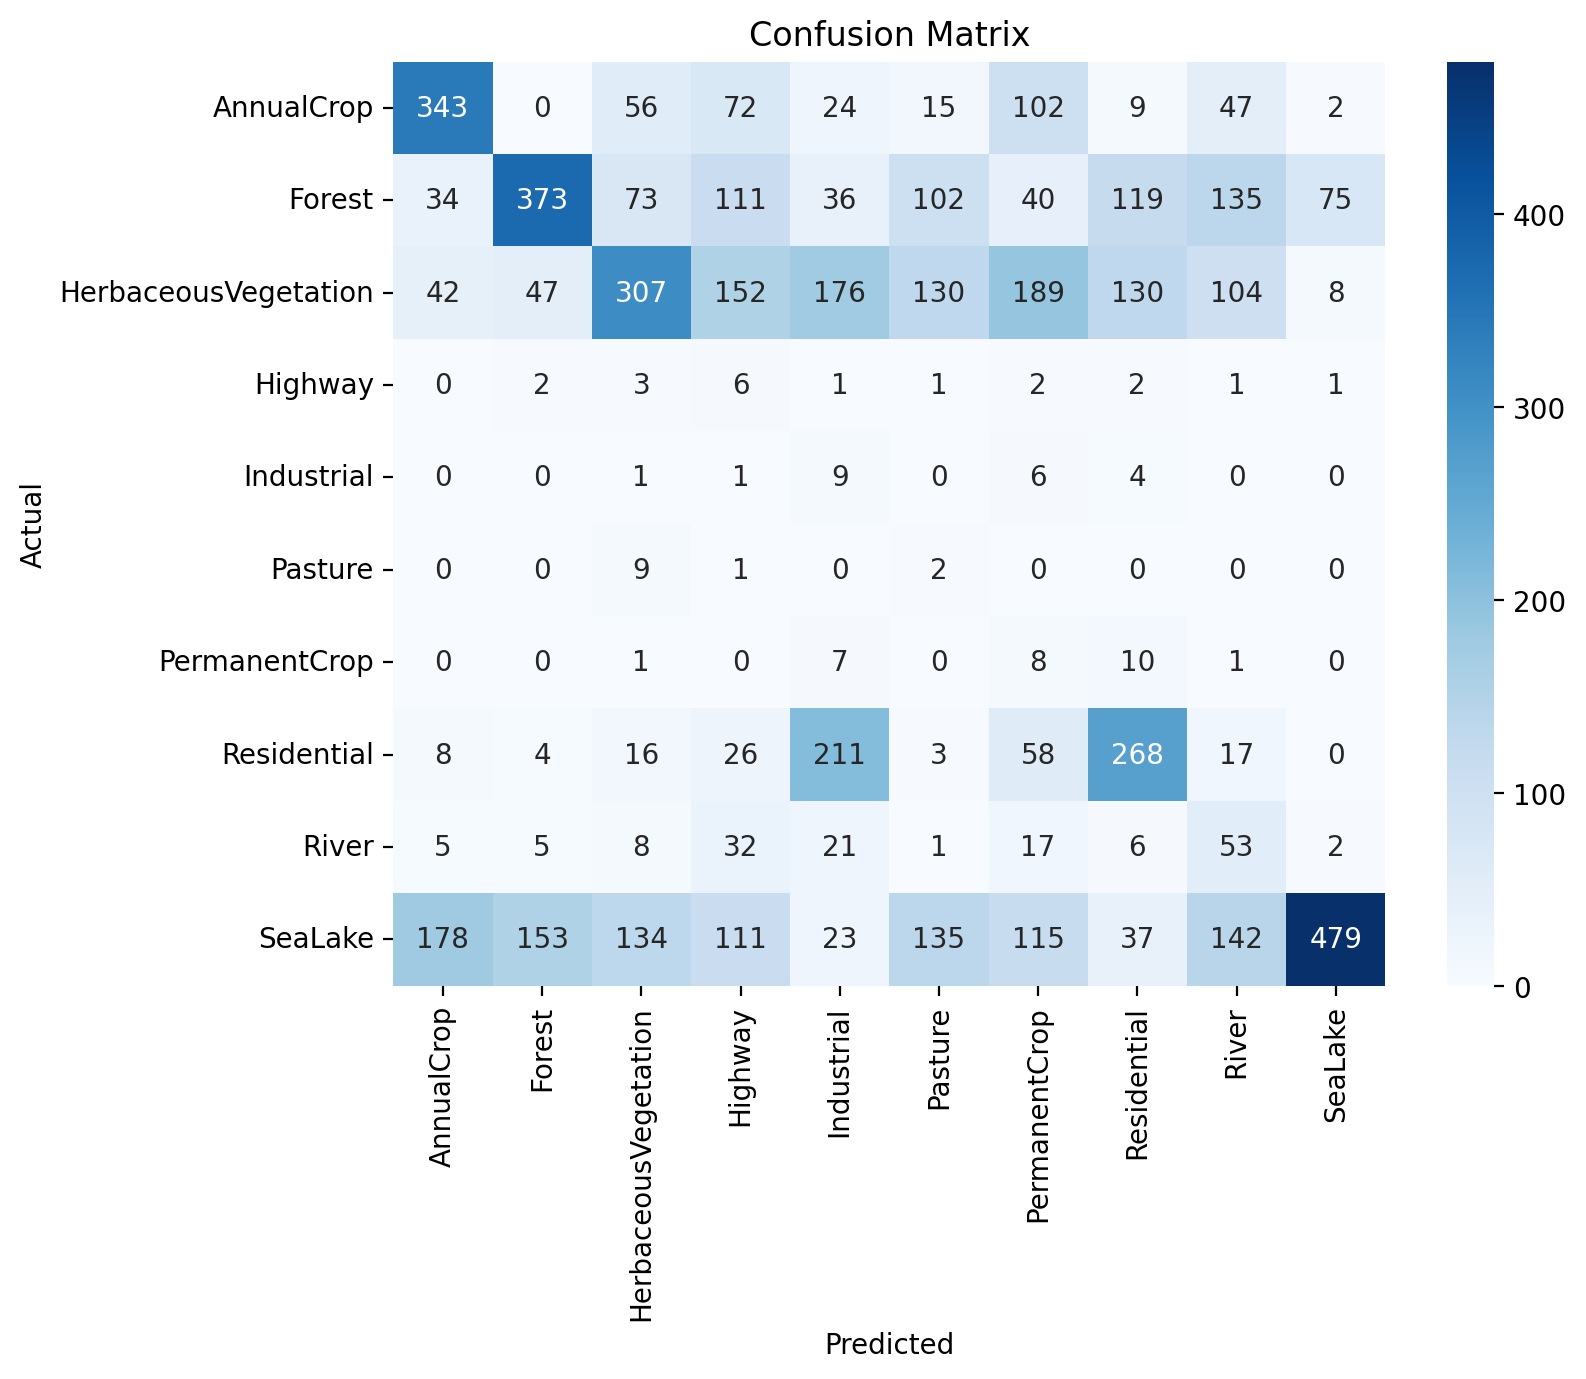

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.51      0.54       670
           1       0.64      0.34      0.44      1098
           2       0.50      0.24      0.32      1285
           3       0.01      0.32      0.02        19
           4       0.02      0.43      0.03        21
           5       0.01      0.17      0.01        12
           6       0.01      0.30      0.03        27
           7       0.46      0.44      0.45       611
           8       0.11      0.35      0.16       150
           9       0.84      0.32      0.46      1507

    accuracy                           0.34      5400
   macro avg       0.32      0.34      0.25      5400
weighted avg       0.61      0.34      0.42      5400



In [40]:
metrics(all_predictions_int8,all_labels_int8)

### QAT

Load a new vgg model which is not trained before starting qat

In [41]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [42]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

In [43]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [44]:
model_prepared.to(device)

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (stem): Module(
    (0): Module(
      (0): ConvBn2d(
        3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127

In [45]:
model_prepared = train(model_prepared,trainloader, validloader,criterion, optimizer,device,epochs,steps,print_every)

Training process initializing .....



/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(


Epoch: 1/5 |  Training Loss: 1.8586 |  Validation Loss: 1.5501 |  Validation Accuracy: 0.4633
Epoch: 1/5 |  Training Loss: 1.3225 |  Validation Loss: 1.2224 |  Validation Accuracy: 0.5848
Epoch: 1/5 |  Training Loss: 1.1596 |  Validation Loss: 1.2730 |  Validation Accuracy: 0.5641
Epoch: 1/5 |  Training Loss: 1.2168 |  Validation Loss: 1.1663 |  Validation Accuracy: 0.6074
Epoch: 1/5 |  Training Loss: 1.1328 |  Validation Loss: 1.1501 |  Validation Accuracy: 0.6081
Epoch: 1/5 |  Training Loss: 1.1355 |  Validation Loss: 1.1390 |  Validation Accuracy: 0.6100
Epoch: 1/5 |  Training Loss: 1.1433 |  Validation Loss: 1.1238 |  Validation Accuracy: 0.6178
Epoch: 1/5 |  Training Loss: 1.0612 |  Validation Loss: 1.1111 |  Validation Accuracy: 0.6211
Epoch: 1/5 |  Training Loss: 1.1064 |  Validation Loss: 1.1144 |  Validation Accuracy: 0.6115
Epoch: 1/5 |  Training Loss: 1.0686 |  Validation Loss: 1.0817 |  Validation Accuracy: 0.6274
Epoch: 1/5 |  Training Loss: 1.0101 |  Validation Loss: 1.08

In [46]:
model_prepared.to('cpu')

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0347]), zero_point=tensor([51], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.7630610466003418, max_val=2.639939546585083)
  )
  (stem): Module(
    (0): Module(
      (0): ConvBn2d(
        3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([2.3166e-02, 5.5256e-07, 2.6183e-02, 7.1043e-07, 3.5790e-02, 6.0881e-03,
                  2.4049e-02, 2.4798e-03, 1.4285e-02, 2.4732e-03, 1.8236e-02, 4.6953e-02,
                  6.8399e-04, 2.1188e

In [47]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [48]:
model_quantized_trained.to('cpu')

GraphModule(
  (stem): Module(
    (0): Module(
      (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.2922305762767792, zero_point=49, padding=(1, 1))
      (2): GELU(approximate='none')
    )
    (1): Module(
      (0): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.14399050176143646, zero_point=52, padding=(1, 1))
    )
  )
  (blocks): Module(
    (0): Module(
      (layers): Module(
        (0): Module(
          (layers): Module(
            (MBconv): Module(
              (proj): Module(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): QuantizedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.03805628791451454, zero_point=39)
              )
              (layers): Module(
                (pre_norm): QuantizedBatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Module(
                  (0): QuantizedConv2d(64, 256, kernel_size=(1, 1), st

In [ ]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

In [ ]:
metrics(all_predictions_int8,all_labels_int8)

In [ ]:
print("Size of fp16 model:",end='')
print_model_size(model_fp16)
print("Size of PTQ model:",end='')
print_model_size(model_quantized_static)
print("Size of QAT model:",end='')
print_model_size(model_quantized_trained)